# Corrupted labels are a useful way to measure a networks generalization potential
- https://arxiv.org/pdf/1611.03530.pdf

In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm as tqdm
# from tqdm.autonotebook import tqdm as autotqdm

import brainscore
from sklearn.preprocessing import LabelEncoder


import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns
%matplotlib inline

from src.data_loader import Shifted_Data_Loader,upsample_dataset
from src.plot import orig_vs_transformed as plot_ovt
from src.plot import enc_dec_samples
from src.models import GResNet,EDense,EConvNet
from src.test_models.infoduplex import INFODCDuplex
from src.test_models.dcduplex import DCDuplex
from src.test_models.drduplex import DRDuplex
from src.published_models.dcgan import DCGAN
from src.config import get_config
from src.trainer import Trainer
from src.utils import prepare_dirs_and_logger
from keras.datasets import fashion_mnist,mnist
from keras.layers import Dense
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import adadelta

# from tabulate import tabulate

Using TensorFlow backend.


In [2]:
config,_ = get_config()
# Boilerplate
setattr(config, 'proj_root', '/home/elijahc/projects/vae')
setattr(config, 'log_dir', '/home/elijahc/projects/vae/logs')
setattr(config, 'dev_mode',False)
setattr(config, 'seed', 7)
setattr(config, 'project','vae')
# setattr(config, 'ecc_max',4.8/8.0)
setattr(config, 'bg_noise',0.0)
# setattr(config, 'contrast_level',0.3)
# setattr(config, 'rot_max',90.0/360.0)
setattr(config, 'rot_max',0)

# Architecture Params
setattr(config, 'enc_layers', [3000,2000,500])
setattr(config, 'enc_arch', 'feedforward')

# setattr(config, 'enc_layers', [3000,2000,500])
# setattr(config, 'enc_arch', 'resnet')

setattr(config, 'dec_blocks', [4,2,1])
setattr(config, 'z_dim', 50)
setattr(config, 'y_dim', 20)

# Training Params
setattr(config, 'batch_size', 512)
setattr(config, 'dataset', 'fashion_mnist')
setattr(config, 'epochs',1200)
setattr(config, 'monitor', None)
# setattr(config, 'lr', 10)
# setattr(config, 'min_delta', 0.25)
# setattr(config, 'monitor', 'val_loss')
setattr(config, 'optimizer', 'nadam')
setattr(config, 'label_corruption',0.0)

# if config.ecc_max == 0.:
#     translation_amt = None
# else:
#     translation_amt = config.ecc_max

# if config.rot_max == 0.:
#     rot_max = None
# else:
#     rot_max = config.rot_max
    
# if config.bg_noise == 0.:
#     bg_noise = None
# else:
#     bg_noise = config.bg_noise

# Loss Weights
setattr(config, 'xcov', 0)
setattr(config, 'recon', 1)
setattr(config, 'xent', 20)
# setattr(config,'model_dir','/home/elijahc/projects/vae/models/2019-05-25/recon_{}_ecc_{}/label_corruption_{}'.format(config.recon,config.ecc_max,config.label_corruption))
setattr(config,'model_dir','/home/elijahc/projects/vae/models/2019-08-13/xent_{}_recon_{}/stim_var_{}'.format(config.xent,config.recon,0))

In [3]:
class MajajDataLoader(object):
    def __init__(self,fp='/home/elijahc/projects/vae/data/dicarlo_images/',flatten=False):
        self.fp = fp
        self.stimulus_set = pd.read_csv(os.path.join(self.fp,'stimulus_set.csv'))
        self.num_classes = len(self.stimulus_set.object_name.drop_duplicates().values)
        self.sm_images = np.load(os.path.join(self.fp,'sm_imgs_56x56.npy'))
        num_images = self.sm_images.shape[0]

        if flatten:
            self.x_all = self.sm_images.reshape(num_images,np.prod(self.sm_images.shape[1:]))
            self.input_shape = (np.prod(self.sm_images.shape[1:]),)
        else:
            self.input_shape = self.sm_images.shape[1:]+(1,)
            self.x_all = self.sm_images.reshape(num_images,*self.input_shape)
            
#         lo_hi_var_idxs = self.stimulus_set.variation!=3
#         med_var_idxs = self.stimulus_set.variation<=3
#         self.x_train = self.x_all[lo_hi_var_idxs]
        self.x_train = self.x_all
#         self.x_test = self.x_all[med_var_idxs]
        
        y_label_encoder = LabelEncoder()
        self.y_train_labels = self.stimulus_set.object_name.values
#         self.y_train_labels = self.stimulus_set.category_name.values[lo_hi_var_idxs]
#         self.y_test_labels = self.stimulus_set.category_name.values[med_var_idxs]
        
        self.y_train = y_label_encoder.fit_transform(self.y_train_labels)
        self.y_train_oh = to_categorical(self.y_train)
        
#         self.y_test = y_label_encoder.fit_transform(self.y_test_labels)
#         self.y_test_oh = to_categorical(self.y_test)
    def training_data(self):
        return (self.x_train,self.y_train_oh)
        

In [4]:
DL = MajajDataLoader()
mod = DRDuplex(img_shape=(56,56,1),
               num_classes=DL.num_classes,
               recon=config.recon,
               xent=config.xent,
               kernel_regularization=0.00005,
              )

In [5]:
mod.combined.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input (InputLayer)        (None, 56, 56, 1)    0                                            
__________________________________________________________________________________________________
Encoder (Model)                 (None, 70)           16448570    model_input[0][0]                
__________________________________________________________________________________________________
Generator (Model)               (None, 56, 56, 1)    168129      Encoder[1][0]                    
__________________________________________________________________________________________________
Classifier (Model)              (None, 64)           16443899    model_input[0][0]                
Total params: 16,629,563
Trainable params: 16,629,051
Non-trainable params: 512
_____________________________

In [6]:
np.random.seed(7)
if not config.dev_mode:
    print('setting up...')
    prepare_dirs_and_logger(config)
    
vars(config)

setting up...
/home/elijahc/projects/vae/logs/0905_135744_fashion_mnist  does not exist...
creating...


{'batch_size': 512,
 'bg_noise': 0.0,
 'dataset': 'fashion_mnist',
 'dec_blocks': [4, 2, 1],
 'dev_mode': False,
 'enc_arch': 'feedforward',
 'enc_layers': [3000, 2000, 500],
 'epochs': 1200,
 'label_corruption': 0.0,
 'log_dir': '/home/elijahc/projects/vae/logs',
 'log_level': 'INFO',
 'model_dir': '/home/elijahc/projects/vae/models/2019-08-13/xent_20_recon_1/stim_var_0',
 'model_name': '0905_135744_fashion_mnist',
 'monitor': None,
 'optimizer': 'nadam',
 'proj_root': '/home/elijahc/projects/vae',
 'project': 'vae',
 'recon': 1,
 'rot_max': 0,
 'run_dir': '/home/elijahc/projects/vae/logs/0905_135744_fashion_mnist',
 'seed': 7,
 'xcov': 0,
 'xent': 20,
 'y_dim': 20,
 'z_dim': 50}

In [7]:
def enc_dec(model,DL):
    rand_im = np.random.randint(0,DL.x_train.shape[0])
    im = DL.x_train[rand_im]

    latent_rep = model.E.predict(im.reshape(1,56,56,1))

    fig,axs = plt.subplots(1,2,figsize=(8,4))

    axs[0].imshow(im.reshape(56,56),cmap='gray')
    axs[1].imshow(model.G.predict(latent_rep).reshape(56,56),cmap='gray')

In [16]:
mod.train(1000,DL,config.batch_size,validation_split=0.10,verbose=0,shuffle=True)

Epoch        loss        G_loss      C_loss      C_acc       val_C_acc   
0:           361.1706    263.9873    4.1687      0.0191      0.0191      
1:           345.5903    248.4095    4.1686      0.0218      0.0104      
2:           324.6677    227.537     4.1662      0.0183      0.0139      
3:           322.1712    225.0545    4.1655      0.017       0.0069      
4:           317.2821    220.2385    4.1619      0.0214      0.0191      
5:           313.0805    216.1463    4.1565      0.0218      0.0156      
6:           309.1433    212.2217    4.156       0.0189      0.0156      
7:           303.1259    206.2934    4.1516      0.0216      0.0174      
8:           297.9636    201.1473    4.1508      0.0226      0.0139      
9:           294.5984    197.8314    4.1484      0.0222      0.0104      
10:          291.5673    194.8375    4.1467      0.0241      0.0226      
11:          288.038     191.3509    4.1446      0.0249      0.0156      
12:          285.3067    188.7275    4

KeyboardInterrupt: 

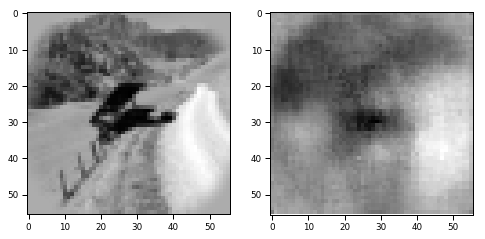

In [22]:
enc_dec(mod,DL)

In [18]:
hist_df = pd.DataFrame.from_records(mod.combined.history.history)
hist_df.head()

,Classifier_acc,Classifier_loss,Generator_loss,Generator_mean_squared_error,loss,val_Classifier_acc,val_Classifier_loss,val_Generator_loss,val_Generator_mean_squared_error,val_loss
0,0.019097,4.168705,263.987283,0.084180,361.170590,0.019097,4.186162,254.255446,0.081076,351.787255
1,0.021798,4.168634,248.409453,0.079212,345.590274,0.010417,4.185663,234.719179,0.074847,332.240065
2,0.018326,4.166175,227.537044,0.072556,324.667689,0.013889,4.182758,239.722748,0.076442,337.184316
3,0.016975,4.165539,225.054486,0.071765,322.171194,0.006944,4.188661,227.660536,0.072596,325.238983
4,0.021412,4.161943,220.238498,0.070229,317.282119,0.019097,4.187420,225.185696,0.071807,322.738149


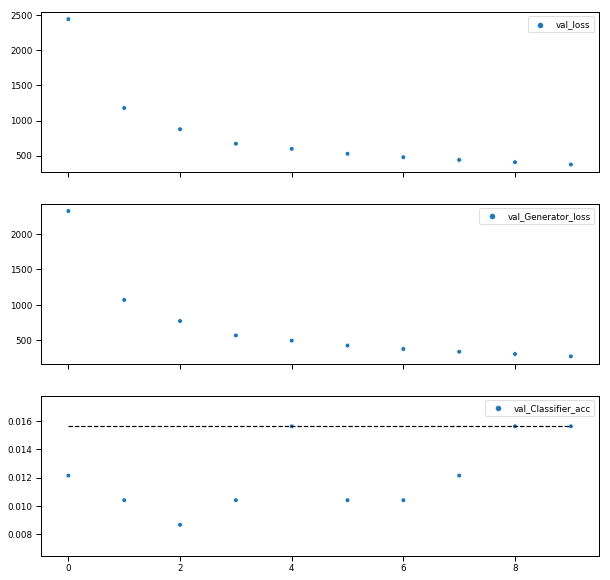

In [11]:
sns.set_context('paper')
metrics = ['loss','Generator_loss','Classifier_acc']
fig,axs = plt.subplots(nrows=len(metrics),sharex=True,figsize=(10,10))
for metric_name,ax in zip(metrics,axs):
    sns.scatterplot(data=hist_df[['val_'+metric_name]],ax=ax)
#     ax.set_xscale('log')
axs[2].hlines(y=(1.0/DL.num_classes),xmin=0,xmax=hist_df.index.values.max(),linestyles='dashed')

In [12]:
# hist_df['generalization_error'] = hist_df.val_loss - hist_df.loss
# hist_df['G_generalization_error'] = hist_df.val_G_loss - hist_df.G_loss
# hist_df['class_generalization_error'] = hist_df.val_class_loss - hist_df.class_loss
# sns.lineplot(data=hist_df[['class_generalization_error']])

In [13]:
import datetime as dt
def clean_config(config,keys=['dev_mode','log_dir','log_level','proj_root']):
    c = vars(config)
    for k in keys:
        if k in c.keys():
            del c[k]
    
    c['uploaded_by']='elijahc'
    c['last_updated']= str(dt.datetime.now())
    return c

In [14]:
run_meta = clean_config(config)
run_meta['project']='vae'
# run_meta['ecc_max']=0.8
run_meta

{'batch_size': 512,
 'bg_noise': 0.0,
 'dataset': 'fashion_mnist',
 'dec_blocks': [4, 2, 1],
 'enc_arch': 'feedforward',
 'enc_layers': [3000, 2000, 500],
 'epochs': 1200,
 'label_corruption': 0.0,
 'last_updated': '2019-09-05 13:58:11.015741',
 'model_dir': '/home/elijahc/projects/vae/models/2019-08-13/xent_20_recon_1/stim_var_0',
 'model_name': '0905_135744_fashion_mnist',
 'monitor': None,
 'optimizer': 'nadam',
 'project': 'vae',
 'recon': 1,
 'rot_max': 0,
 'run_dir': '/home/elijahc/projects/vae/logs/0905_135744_fashion_mnist',
 'seed': 7,
 'uploaded_by': 'elijahc',
 'xcov': 0,
 'xent': 20,
 'y_dim': 20,
 'z_dim': 50}

In [15]:
trainer.save_model()
run_conf = clean_config(config)

with open(os.path.join(run_conf['model_dir'],'config.json'), 'w') as fp:
    json.dump(run_conf, fp)

hist_df.to_parquet(os.path.join(run_conf['model_dir'],'train_history.parquet'))

NameError: name 'trainer' is not defined

In [ ]:
generator = trainer.G

In [ ]:
trainer.E.summary()

In [ ]:
trainer.model.get_layer(name='dense_1').output

In [ ]:
z_encoder = Model(trainer.input,trainer.z_lat)
classifier = Model(trainer.input,trainer.y_class)
y_encoder = Model(trainer.input, trainer.y_lat)

l1_encoder = Model(trainer.input,trainer.model.get_layer(name='dense_1').output)
l2_encoder = Model(trainer.input,trainer.model.get_layer(name='dense_2').output)
l3_encoder = Model(trainer.input,trainer.model.get_layer(name='dense_3').output)

In [ ]:
mod = trainer.model

In [ ]:
mod.summary()

In [ ]:
def get_weight_grad(model, inputs, outputs):
    """ Gets gradient of model for given inputs and outputs for all weights"""
    grads = model.optimizer.get_gradients(model.total_loss, model.trainable_weights)
    symb_inputs = (model._feed_inputs + model._feed_targets + model._feed_sample_weights)
    f = K.function(symb_inputs, grads)
    x, y, sample_weight = model._standardize_user_data(inputs, outputs)
    output_grad = f(x + y + sample_weight)
    return output_grad

In [ ]:
# generator.summary()

In [ ]:
classifier.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
# res = classifier.evaluate(DL_dicarlo.sx_test,DL.y_test_oh,batch_size=config.batch_size)
# ts_error = 1-res[1]
# print(res[1])
# df = pd.DataFrame.from_records({'test_acc':[res[1]],
#                                 'label_corruption':[config.label_corruption],
#                                 'recon':[config.recon],
#                                 'xent':[config.xent],
#                                 'ecc_max':[config.ecc_max],
#                                 'xcov': [config.xcov]})
# df.to_json(os.path.join(config.model_dir,'performance.json'))

In [ ]:
DL = DL_dicarlo

In [ ]:
l1_enc = l1_encoder.predict(DL_dicarlo.x_train,batch_size=config.batch_size)
l2_enc = l2_encoder.predict(DL_dicarlo.x_train,batch_size=config.batch_size)
l3_enc = l3_encoder.predict(DL_dicarlo.x_train,batch_size=config.batch_size)


z_enc = z_encoder.predict(DL.x_train,batch_size=config.batch_size)
# y_lat = y_lat_encoder.predict(DL.sx_test,batch_size=config.batch_size)
y_enc = y_encoder.predict(DL.x_train,batch_size=config.batch_size)

In [ ]:
z_enc_tr = z_encoder.predict(DL.x_train,batch_size=config.batch_size)
# y_lat = y_lat_encoder.predict(DL.sx_test,batch_size=config.batch_size)
y_enc_tr = y_encoder.predict(DL.x_train,batch_size=config.batch_size)

In [ ]:
import xarray
import hashlib
def raw_to_xr(encodings,l_2_depth,stimulus_set):
    obj_names = [
        "T-shirt",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Dress Shirt",
        "Sneaker",
        "Bag",
        "Ankle boot",
    ]
    all_das = []
    for layer,activations in encodings.items():
        neuroid_n = activations.shape[1]
        n_idx = pd.MultiIndex.from_arrays([
            pd.Series(['{}_{}'.format(layer,i) for i in np.arange(neuroid_n)],name='neuroid_id'),
            pd.Series([l_2_depth[layer]]*neuroid_n,name='layer'),
            pd.Series([layer]*neuroid_n,name='region')
        ])
        p_idx = pd.MultiIndex.from_arrays([
            stimulus_set.image_id,
            stimulus_set.dx,
            stimulus_set.dy,
            stimulus_set.rxy,
            stimulus_set.numeric_label.astype('int8'),
            pd.Series([obj_names[i] for i in stimulus_set.numeric_label],name='object_name'),
            pd.Series(stimulus_set.dx.values/28, name='tx'),
            pd.Series(stimulus_set.dy.values/28, name='ty'),
            pd.Series([1.0]*len(stimulus_set),name='s'),
        ])
        da = xarray.DataArray(activations.astype('float32'),
                         coords={'presentation':p_idx,'neuroid':n_idx},
                         dims=['presentation','neuroid'])
        all_das.append(da)
        
    return xarray.concat(all_das,dim='neuroid')

In [ ]:
encodings = {
    'pixel':DL.sx_test,
    'dense_1':l1_enc,
    'dense_2':l2_enc,
    'dense_3':l3_enc,
    'y_lat':y_enc,
    'z_lat':z_enc
}
depths = {
    'pixel':0,
    'dense_1':1,
    'dense_2':2,
    'dense_3':3,
    'y_lat':4,
    'z_lat':4
}
slug = [(dx,dy,float(lab),float(random.randrange(20))) for dx,dy,rxy,lab in zip(DL.dx[1],DL.dy[1],DL.dtheta[1],DL.y_test)]
image_id = [hashlib.md5(json.dumps(list(p),sort_keys=True).encode('utf-8')).digest().hex() for p in slug]
stim_set = pd.DataFrame({'dx':DL.dx[1]-14,'dy':DL.dy[1]-14,'numeric_label':DL.y_test,'rxy':DL.dtheta[1],'image_id':image_id})

In [ ]:
out = raw_to_xr(encodings,depths,stim_set)

In [ ]:
from collections import OrderedDict
def save_assembly(da,run_dir,fname,**kwargs):
    da = da.reset_index(da.coords.dims)
    da.attrs = OrderedDict()
    with open(os.path.join(run_dir,fname), 'wb') as fp:
        da.to_netcdf(fp,**kwargs)
        
    
save_assembly(out,run_dir=config.model_dir,fname='dataset.nc',
    format='NETCDF3_64BIT',
#         engine=
#         encoding=enc,
)

In [ ]:
np.save(os.path.join(config.model_dir,'z_enc'),z_enc)
np.save(os.path.join(config.model_dir,'l1_enc'),l1_enc)
np.save(os.path.join(config.model_dir,'l2_enc'),l2_enc)
np.save(os.path.join(config.model_dir,'l3_enc'),l3_enc)
np.save(os.path.join(config.model_dir,'y_enc'),y_enc)

In [ ]:
_lat_vec = np.concatenate([y_enc,z_enc],axis=1)
_lat_vec.shape

In [ ]:
z_enc_mu = np.mean(z_enc,axis=0)
z_enc_cov = np.cov(z_enc,rowvar=False)

In [ ]:
np.random.multivariate_normal(z_enc_mu,z_enc_cov,size=50).shape

In [ ]:
regen = generator.predict(_lat_vec,batch_size=config.batch_size)

In [ ]:
DL2 = Shifted_Data_Loader(dataset=config.dataset,flatten=True,
                          rotation=None,
                          translation=translation_amt,
                          bg_noise=bg_noise,
                          bg_only=False,
                        )

In [ ]:
enc_dec_samples(DL.x_train,DL.x_train,z_enc_tr,y_enc_tr,generator)

In [ ]:
# enc_dec_samples(DL.x_test,DL.x_test,z_enc,y_enc,generator)

In [ ]:
z_enc2 = z_encoder.predict(DL2.sx_test,batch_size=config.batch_size)
y_lat2 = y_encoder.predict(DL2.sx_test,batch_size=config.batch_size)
_lat_vec2 = np.concatenate([y_lat2,z_enc2],axis=1)
regen2 = generator.predict(_lat_vec2,batch_size=config.batch_size)

In [ ]:
from src.plot import remove_axes,remove_labels
from src.utils import gen_trajectory

In [ ]:
examples = 5
rand_im = np.random.randint(0,10000,size=examples)
fix,axs = plt.subplots(examples,11,figsize=(8,4))
_lat_s = []
regen_s = []
out = gen_trajectory(z_enc[rand_im],z_enc2[rand_im],delta=.25)
out_y = gen_trajectory(y_enc[rand_im],y_lat2[rand_im],delta=.25)

for z,y in zip(out,out_y):
    _lat = np.concatenate([y,z],axis=1)
    _lat_s.append(_lat)
    regen_s.append(generator.predict(_lat,batch_size=config.batch_size))

i=0
for axr,idx in zip(axs,rand_im):
    axr[0].imshow(DL.x_test[idx].reshape(28,28),cmap='gray')
    axr[1].imshow(DL.sx_test[idx].reshape(56,56),cmap='gray')
    axr[2].imshow(regen[idx].reshape(56,56),cmap='gray')
    for j,a in enumerate(axr[3:-3]):
        a.imshow(regen_s[j][i,:].reshape(56,56),cmap='gray')
#         a.imshow(s.reshape(56,56),cmap='gray')
    axr[-3].imshow(regen2[idx].reshape(56,56),cmap='gray')
    axr[-2].imshow(DL2.sx_test[idx].reshape(56,56),cmap='gray')
    axr[-1].imshow(DL2.x_test[idx].reshape(28,28),cmap='gray')
    for a in axr:
        remove_axes(a)
        remove_labels(a)
    i+=1
# plt.imshow(regen[rand_im].reshape(56,56),cmap='gray')

In [ ]:
# fix.savefig('../../updates/2019-02-05/assets/img/translocate_{}.png'.format(translation_amt))

In [ ]:
fdjsakl;fdsa

In [ ]:
dxs = DL.dx[1]-14
dys = DL.dy[1]-14

In [ ]:
from sklearn.preprocessing import MinMaxScaler

feat_range = (0,30)
z_enc_scaled = [MinMaxScaler(feat_range).fit_transform(z_enc[:,i].reshape(-1,1)).tolist() for i in np.arange(10)]
z_enc_scaled = np.squeeze(np.array(z_enc_scaled,dtype=int))

In [ ]:
y_enc_scaled = [MinMaxScaler(feat_range).fit_transform(y_enc[:,i].reshape(-1,1)).tolist() for i in np.arange(10)]
y_enc_scaled = np.squeeze(np.array(y_enc_scaled,dtype=int))

In [ ]:
l2_enc_scaled = [MinMaxScaler(feat_range).fit_transform(l2_enc[:,i].reshape(-1,1)).tolist() for i in np.arange(2000)]
l2_enc_scaled = np.squeeze(np.array(l2_enc_scaled,dtype=int))

In [ ]:
l2_enc_scaled.shape

In [ ]:
from collections import Counter
import dit
from dit import Distribution

def mutual_information(X,Y):
    XY_c = Counter(zip(X,Y))
    XY_pmf = {k:v/float(sum(XY_c.values())) for k,v in XY_c.items()}
    XY_jdist = Distribution(XY_pmf)
        
    return dit.shannon.mutual_information(XY_jdist,[0],[1])

In [ ]:
z_dx_I = [mutual_information(z_enc_scaled[i],dxs.astype(int)+14) for i in np.arange(5)]
# l2_dx_I = [mutual_information(l2_enc_scaled[i],dxs.astype(int)+14) for i in np.arange(2000)]

In [ ]:
z_dy_I = [mutual_information(z_enc_scaled[i],dys.astype(int)+14) for i in np.arange(5)]
# l2_dy_I = [mutual_information(l2_enc_scaled[i],dys.astype(int)+14) for i in np.arange(2000)]

In [ ]:
z_class_I = [mutual_information(z_enc_scaled[i],DL.y_test) for i in np.arange(5)]
# l2_class_I = [mutual_information(l2_enc_scaled[i],DL.y_test) for i in np.arange(2000)]

In [ ]:
z_I_df = pd.DataFrame.from_records({'class':z_class_I,'dy':z_dy_I,'dx':z_dx_I})
z_I_df['class'] = z_I_df['class'].values.round(decimals=1)

In [ ]:
l2_I_df = pd.DataFrame.from_records({
    'class':l2_class_I,
    'dy':l2_dy_I,
    'dx':l2_dx_I})
l2_I_df['class'] = l2_I_df['class'].values.round(decimals=1)

In [ ]:
z_I_df.head()

In [ ]:
l2_I_df.head()

In [ ]:
plt.hist(l2_I_df.dx)

In [ ]:
plt.hist(z_I_df.dx)

In [ ]:
config.translation_amt = translation_amt
config.translation_amt

In [ ]:
dir_path = '../data/xcov_importance/dist_{}/'.format(translation_amt)

z_I_df.to_pickle('../data/xcov_importance/dist_{}/z_mutual_info.pk'.format(translation_amt))
np.save('../data/xcov_importance/dist_{}/dxs'.format(translation_amt), DL.dx[1]-14)
np.save('../data/xcov_importance/dist_{}/dys'.format(translation_amt), DL.dy[1]-14)
np.save('../data/xcov_importance/dist_{}/z_enc'.format(translation_amt), z_enc)

hist_df.to_pickle(os.path.join(dir_path,'training_hist.df'))

with open(os.path.join(dir_path,'config.json'), 'w') as fp:
        json.dump(vars(config), fp)

In [ ]:
def filter_by_weight(wts,thresh=0.01):
    idxs = np.abs(wts)>thresh
    return idxs

In [ ]:
dx_max = np.argmax(z_I_df.dx.values)
dy_max = np.argmax(z_I_df.dy.values)

In [ ]:
t = 0.05
dx_filt = filter_by_weight(z_w_k[:,dx_max],thresh=t)
dy_filt = filter_by_weight(z_w_k[:,dy_max],thresh=t)
union = np.union1d(np.where(dx_filt==True),np.where(dy_filt==True))
intersect = np.intersect1d(np.where(dx_filt==True),np.where(dy_filt==True))
# filt = np.array([False]*2000)
# filt[union] = True

sns.set_context('talk')
fig,axs = plt.subplots(1,2,figsize=(6*2,5))

filt = dy_filt
print('num: ',len(union))
print('intersect_frac: ',float(len(intersect))/len(union))
print('mean dx_I: ',l2_I_df.dx[filt].mean())
print('mean dy_I: ',l2_I_df.dy[filt].mean())
points = axs[0].scatter(x=l2_I_df['dx'],y=l2_I_df['dy'],
                        c=l2_I_df['class'],cmap='viridis',vmin=0,vmax=0.4,s=z_I_df['class']*100
                       )
plt.colorbar(points)
points = axs[1].scatter(x=z_I_df['dx'],y=z_I_df['dy'],c=z_I_df['class'],cmap='viridis',s=z_I_df['class']*100,vmin=0,vmax=0.4)
# plt.colorbar(points)
axs[0].set_ylim(0,0.9)
axs[0].set_xlim(0,0.9)
axs[1].set_ylim(0,0.9)
axs[1].set_xlim(0,0.9)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(z_dx_I,z_dy_I)
# ax.set_ylim(0,0.8)
# ax.set_xlim(0,0.8)

In [ ]:
plt.scatter(np.arange(25),sorted(z_class_I,reverse=True))
# plt.scatter(np.arange(25),z_dx_I)
# plt.scatter(np.arange(25),z_dy_I)

In [ ]:
from src.metrics import var_expl,norm_var_expl
from collections import Counter

dtheta = DL.dtheta[1]
fve_dx = norm_var_expl(features=z_enc,cond=dxs,bins=21)
fve_dy = norm_var_expl(features=z_enc,cond=dys,bins=21)
fve_class = norm_var_expl(features=z_enc, cond=DL.y_test, bins=21)
# fve_dt = norm_var_expl(features=z_enc,cond=dtheta,bins=21)

In [ ]:
# fve_dx_norm = (dxs.var()-fve_dx)/dxs.var()
# fve_dy_norm = (dys.var()-fve_dy)/dys.var()
# fve_dth_norm = (dtheta.var()-fve_dt)/dtheta.var()
fve_dx_norm = fve_dx
fve_dy_norm = fve_dy

In [ ]:
import seaborn as sns
sns.set_context('talk')

In [ ]:
fve_dx_norm.shape
# np.save(os.path.join(config.model_dir,'fve_dx_norm'),fve_dx_norm)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
plt.scatter(fve_dx_norm.mean(axis=0),fve_dy_norm.mean(axis=0))
plt.xlabel('fve_dx')
plt.ylabel('fve_dy')
plt.tight_layout()
# plt.savefig(os.path.join(config.model_dir,'fve_dx.png'))
# plt.ylim(-0.125,0.25)
xdim = np.argmax(fve_dx_norm.mean(axis=0))

In [ ]:
fve_dy_norm.mean(axis=0)
# np.save(os.path.join(config.model_dir,'fve_dy_norm'),fve_dy_norm)

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_dy_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dy')
plt.tight_layout()
# plt.savefig(os.path.join(config.model_dir,'fve_dy.png'))
# plt.ylim(-0.125,0.25)
ydim = np.argmax(fve_dy_norm.mean(axis=0))

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_class.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_class')
# plt.ylim(0.0,0.5)
np.argmax(fve_class.mean(axis=0))

In [ ]:
from src.plot import Z_color_scatter
Z_color_scatter(z_enc,[xdim,ydim],dxs)

In [ ]:
Z_color_scatter(z_enc,[xdim,ydim],dys)

In [ ]:
Z_color_scatter(z_enc,[7,18],dtheta)

In [ ]:
from plt.